In [1]:
import sys
venv_root = '/var/lib/vz/data/c17000697/DEEP/'
sys.path.append(venv_root + 'lib/python3.5/site-packages')

import warnings
warnings.filterwarnings('ignore')
import os

os.environ["CUDA_DEVICE_VISIBLE"]="0"

In [2]:
import load_caption

#features,texts=load_caption.extract_features_caption(save_all=True)
#print(features.shape)
#print(len(texts))

Using TensorFlow backend.


In [3]:
import numpy as np
def load(captions_filename, features_filename):
    features = np.load(features_filename)
    images = []
    texts = []
    with open(captions_filename) as fp:
        for line in fp:
            tokens = line.strip().split()
            images.append(tokens[0])
            texts.append(' '.join(tokens[1:]))
    return features, images, texts
features,images,texts=load('../train.captions.txt','../resnet50-features.train.40k.npy')
#print(features.shape)
#print(len(texts))

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
print(len(texts))
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
captions = pad_sequences(sequences, maxlen=16)

# It’s the right time to save the vocabulary so that we can reload it later.
vocab = tokenizer.word_index
vocab['<eos>'] = 0

# add word with id 0
import json
with open('vocab.json', 'w') as fp:
    # save the vocab
    fp.write(json.dumps(vocab))

414113


In [5]:
len(vocab)

22679

In [6]:
import embedding


embedding_weights = embedding.load(vocab, 100, '../embeddings/glove.twitter.27B.100d.filtered.txt')

loading embeddings from "../embeddings/glove.twitter.27B.100d.filtered.txt"


In [7]:
def create_tsv(filename):
    print('loading embeddings from "%s"' % filename, file=sys.stderr)
    with open(filename) as fp,open(filename+'_metadata.tsv','w+') as fp3,open(filename+".tsv",'w+') as fp2:
        for line in fp:
            vector = line.strip().split(' ',1)[1]
            tokens = vector.split(' ')
            for i in range(len(tokens)-2):
                fp2.write(tokens[i]+'\t')
            fp2.write(tokens[len(tokens)-1]+'\n')
            fp3.write(line.strip().split(' ',1)[0]+"\n")
#create_tsv('./embeddings/glove.twitter.27B.100d.filtered.txt')

In [11]:
import numpy as np
import json
import keras
from nltk.tokenize import word_tokenize, sent_tokenize
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from attention import Attention
from keras.applications.imagenet_utils import preprocess_input

image_input = keras.layers.Input(shape=(2048,))
caption_input = keras.layers.Input(shape=(16,))
noise_input = keras.layers.Input(shape=(16,))

caption_embedding = keras.layers.Embedding(len(vocab), 100, input_length=16, weights=[embedding_weights])
caption_rnn = keras.layers.LSTM(256,return_sequences=True)
image_dense = keras.layers.Dense(256, activation='tanh')

attention = Attention()
image_pipeline = image_dense(image_input)
caption_pipeline = attention(caption_rnn(caption_embedding(caption_input)))
noise_pipeline = attention(caption_rnn(caption_embedding(noise_input)))

positive_pair = keras.layers.dot([image_pipeline, caption_pipeline], axes=1)
negative_pair = keras.layers.dot([image_pipeline, noise_pipeline], axes=1)
output = keras.layers.concatenate([positive_pair, negative_pair])

training_model = keras.models.Model(input=[image_input, caption_input, noise_input], output=output)
image_model = keras.models.Model(input=image_input, output=image_pipeline)
caption_model = keras.models.Model(input=caption_input, output=caption_pipeline)

training_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 16, 100)      2267900     input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________

In [17]:
from keras import backend as K

def custom_loss(y_true, y_pred):
    positive = y_pred[:,0]
    negative = y_pred[:,1]
    return K.sum(K.maximum(0., 1. - positive + negative))

def accuracy(y_true, y_pred):
    positive = y_pred[:,0]
    negative = y_pred[:,1]
    return K.mean(positive > negative)

In [13]:
training_model.compile(loss=custom_loss, optimizer='adam', metrics=[accuracy])

In [ ]:
from keras.callbacks import TensorBoard
from time import time
noise = np.copy(captions)
fake_labels = np.zeros((len(features), 1))
X_train = [features[:35504], captions[:35504], noise[:35504]]
Y_train = fake_labels[:35504]
X_valid = [features[-5000:], captions[-5000:], noise[-5000:]]
Y_valid = fake_labels[-5000:]

tensorboard = TensorBoard(log_dir='./logs/{}'.format(time()), histogram_freq=0,write_graph=True, write_images=False)
shuffle_callback = keras.callbacks.LambdaCallback(on_epoch_begin=lambda epochs, logs: np.random.shuffle(noise))
nb_epoch = 50

h = training_model.fit(X_train, Y_train, validation_data=[X_valid, Y_valid], nb_epoch=nb_epoch, batch_size=128, verbose=1,callbacks=[shuffle_callback,tensorboard])

Train on 35504 samples, validate on 5000 samples
Epoch 1/50
35504/35504 [==============================] - 16s 446us/step - loss: 25.5162 - accuracy: 0.9177 - val_loss: 19.3799 - val_accuracy: 0.9424
Epoch 2/50
35504/35504 [==============================] - 14s 407us/step - loss: 13.0344 - accuracy: 0.9598 - val_loss: 14.6236 - val_accuracy: 0.9542
Epoch 3/50
35504/35504 [==============================] - 14s 397us/step - loss: 10.4442 - accuracy: 0.9666 - val_loss: 12.8686 - val_accuracy: 0.9612
Epoch 4/50
35504/35504 [==============================] - 14s 394us/step - loss: 8.8451 - accuracy: 0.9726 - val_loss: 12.5985 - val_accuracy: 0.9610
Epoch 5/50
35504/35504 [==============================] - 14s 392us/step - loss: 7.9061 - accuracy: 0.9764 - val_loss: 11.5041 - val_accuracy: 0.9648
Epoch 6/50
35504/35504 [==============================] - 14s 396us/step - loss: 7.4016 - accuracy: 0.9760 - val_loss: 11.0546 - val_accuracy: 0.9632
Epoch 7/50
35504/35504 [========================

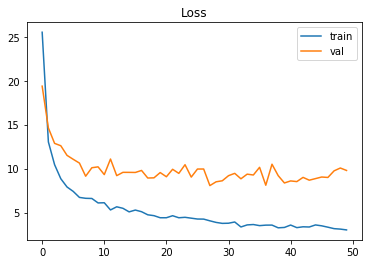

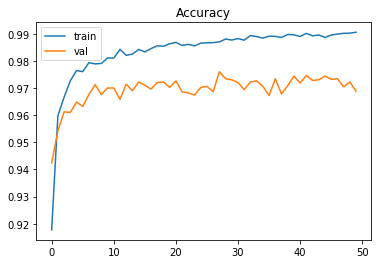

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plt = np.arange(nb_epoch)
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(x_plt, h.history['accuracy'], label='train')
plt.plot(x_plt, h.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()
plt.show()

In [19]:
#from imagenet_utils import preprocess_input
resnet_model = ResNet50(weights='imagenet', include_top=False,pooling="avg")
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = resnet_model.predict(x)
    return np.expand_dims(features.flatten(), axis=0)

In [20]:
caption_model.save('model.caption')
np.save('caption-representations',caption_model.predict(captions))

In [21]:
caption_representations = np.load('caption-representations.npy')

In [22]:
def generate_caption(image_filename, n=50):
    image_representation =image_model.predict(extract_features(image_filename))
    scores = np.dot(caption_representations,image_representation.T).flatten()
    indices = np.argpartition(scores, -n)[-n:]
    indices = indices[np.argsort(scores[indices])]
    print(indices)
    for i in [int(x) for x in reversed(indices)]:
        print(scores[i], texts[i])


In [25]:
generate_caption('../data/test2014/COCO_test2014_000000000016.jpg')

[270832 340687 392119 340757 335966 345905 413646 152178  96687   4498
 214243 142781  50596 403934 214305  30124 255458 264159  69634 408921
 240117 413641 383429 281184 214296  19712  53692  84797 347634 214242
  76301 219736 325942  84965 275949  79507 264992 413654  28446 163199
 245021  19660  86545   4488 388680 281236 142770 408972 357846 212830]
7.342305 a man with a baseball glove holding a baseball
7.3317595 a man with a baseball bat in front of a man with a glove
7.3317595 a man with a baseball bat in front of a man with a glove
7.23167 a man with a baseball bat standing in front of a man with a ball
7.101082 a man wearing a baseball glove and holding a baseball
7.090976 a man who is holding a baseball bat playing baseball
7.042645 a person with a baseball bat in the middle of a swing
7.0113516 a man holding a baseball bat an playing baseball
7.0061507 a man with a baseball bat playing baseball
6.9744678 a man playing baseball is preparing to swing his bat at a baseball
6.95

In [60]:
caption_representations[0]

array([ 1.44150183e-02,  6.38967101e-03, -1.19430594e-01,  2.03568563e-02,
        7.04848766e-02, -5.60400635e-03, -7.83167332e-02,  5.00726029e-02,
        7.49871582e-02, -4.44310009e-02,  1.46888554e-01, -3.54131907e-02,
       -6.87035471e-02, -2.16380164e-01,  6.61126599e-02, -9.31951869e-03,
       -7.23102540e-02, -4.64675128e-02,  5.27889207e-02,  1.04308173e-01,
        1.97082236e-01,  1.63479239e-01, -2.62290761e-02,  1.85486272e-01,
       -1.85691521e-01, -2.25510029e-03,  2.42771208e-02,  3.45366970e-02,
        1.28807381e-01,  1.18435463e-02, -3.94895583e-01,  2.60396332e-01,
        1.64383985e-02, -7.91222975e-02, -7.00553926e-03,  1.92818642e-01,
        1.30232982e-02,  2.05963284e-01, -1.15039364e-01, -5.84230721e-02,
       -7.34710991e-02, -1.41879871e-01, -4.36179340e-01, -2.33967811e-01,
       -3.17076035e-02, -2.80960258e-02,  2.69154995e-03,  2.08860487e-01,
        1.14576854e-02, -1.19928613e-01, -9.86498967e-02,  3.23925726e-02,
        1.05228378e-02, -

In [27]:
import numpy as np
import json
import keras
from nltk.tokenize import word_tokenize, sent_tokenize
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image

from keras.applications.imagenet_utils import preprocess_input

image_input = keras.layers.Input(shape=(2048,))
caption_input = keras.layers.Input(shape=(16,))
noise_input = keras.layers.Input(shape=(16,))

caption_embedding = keras.layers.Embedding(len(vocab), 100, input_length=16, weights=[embedding_weights])
caption_rnn = keras.layers.GRU(256)
image_dense = keras.layers.Dense(256, activation='tanh')

image_pipeline = image_dense(image_input)
caption_pipeline = caption_rnn(caption_embedding(caption_input))
noise_pipeline = caption_rnn(caption_embedding(noise_input))

positive_pair = keras.layers.dot([image_pipeline, caption_pipeline], axes=1)
negative_pair = keras.layers.dot([image_pipeline, noise_pipeline], axes=1)
output = keras.layers.concatenate([positive_pair, negative_pair])

training_model = keras.models.Model(input=[image_input, caption_input, noise_input], output=output)
image_model = keras.models.Model(input=image_input, output=image_pipeline)
caption_model = keras.models.Model(input=caption_input, output=caption_pipeline)

training_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16)           0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 16)           0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 16, 100)      2267900     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________

In [28]:
from keras.callbacks import TensorBoard
from time import time
training_model.compile(loss=custom_loss, optimizer='adam', metrics=[accuracy])

noise = np.copy(captions)
fake_labels = np.zeros((len(features), 1))
X_train = [features[:35504], captions[:35504], noise[:35504]]
Y_train = fake_labels[:35504]
X_valid = [features[-5000:], captions[-5000:], noise[-5000:]]
Y_valid = fake_labels[-5000:]

tensorboard = TensorBoard(log_dir='./logs/{}'.format(time()), histogram_freq=0,write_graph=True, write_images=False)
shuffle_callback = keras.callbacks.LambdaCallback(on_epoch_begin=lambda epochs, logs: np.random.shuffle(noise))
nb_epoch = 50

h = training_model.fit(X_train, Y_train, validation_data=[X_valid, Y_valid], nb_epoch=nb_epoch, batch_size=64, verbose=0,callbacks=[shuffle_callback,tensorboard])

In [29]:
caption_model.save('model.caption')
np.save('caption-representations',caption_model.predict(captions))
caption_representations = np.load('caption-representations.npy')

In [30]:
def generate_caption(image_filename, n=10):
    image_representation =image_model.predict(extract_features(image_filename))
    scores = np.dot(caption_representations,image_representation.T).flatten()
    indices = np.argpartition(scores, -n)[-n:]
    indices = indices[np.argsort(scores[indices])]
    print(indices)
    for i in [int(x) for x in reversed(indices)]:
        print(scores[i], texts[i])


In [31]:
generate_caption('../data/test2014/COCO_test2014_000000000016.jpg')

[341925  19645 270815 393813   4447 168287 351239 403924 146167  12959]
13.158798 a pitcher throwing a baseball to home plate with a catcher and umpire waiting for the ball
13.112135 a baseball player at bat swinging his bat and a catcher behind the plate holding his glove out
12.918356 a baseball player getting ready to bat while a catcher squats behind him preparing to catch the ball
12.83173 two baseball players a catcher and a ball player with a bat held in swing position stand ready
12.801717 a baseball player at bat with a catcher and umpire behind him and people watching from the stands
12.674946 a youth baseball game with a player at bat and a catcher behind home plate with his glove out
12.623693 a batter poised to hit the ball in front of a catcher and umpire during a game
12.616161 a baseball player is ready to swing at the ball as the catcher and umpire crouch behind him
12.417097 a batter swings at the ball in a baseball game with the catcher and umpire behind him
12.41484